In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline


from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, FreqDist

from wordcloud import WordCloud

import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

%matplotlib inline


In [3]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gburgess/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
jigsaw_df = pd.read_csv('../data/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv')

In [5]:
is_toxic = (jigsaw_df['toxicity'] >= 0.5) | (jigsaw_df['severe_toxicity'] >= 0.1) | \
            (jigsaw_df['obscene'] >= 0.25) | (jigsaw_df['sexual_explicit'] >= 0.25) | \
            (jigsaw_df['identity_attack'] >= 0.25) | (jigsaw_df['insult'] >= 0.25) | \
            (jigsaw_df['threat'] >= 0.10)

In [6]:
new_target_df = pd.DataFrame()
new_target_df[['id', 'comment_text']] = jigsaw_df[['id', 'comment_text']].copy()
new_target_df['target'] = (is_toxic).astype(int)
new_target_df.info(show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   id            1999516 non-null  int64 
 1   comment_text  1999515 non-null  object
 2   target        1999516 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


In [7]:
# remove single row with NaN in `comment_text` (probably there just for fun!)
new_target_df.dropna(inplace=True)

In [8]:
del jigsaw_df

In [9]:
is_target = (new_target_df['target'] == 1)
num_targets = sum(is_target)
num_targets

338409

In [10]:
majority_df = resample(new_target_df[ is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

minority_df = resample(new_target_df[ ~is_target ],
                       replace=False,
                       n_samples=num_targets,
                       random_state=42)

train_df = pd.concat([majority_df, minority_df])
train_df['target'].value_counts()

1    338409
0    338409
Name: target, dtype: int64

In [11]:
# # save training df to reuse it later without re-creating it
# train_df.to_csv('../data/train_df.csv', index=False)

# # load train df so you don't need to re-create it
# train_df = pd.read_csv('../data/train_df.csv')

In [96]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [97]:
# Added 'us' to stopwords, because the lemmatizer reduces it to 'u'
sw = stopwords.words('english') + ['us']

def word_processor(comment, stopword_list=sw):
    # tokenize (simultaneously removes punctuation)
    tokenizer = RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(comment)

    # lowercase and remove stopwords
    words = [word.lower() for word in words if word.lower() not in stopword_list]
    
    # lemmatize (accounting for part of speech)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1])) 
             for word in pos_tag(words)]

    return ' '.join(words)

In [18]:
%%time
train_df['proc_text'] = train_df['comment_text'].map(word_processor)

CPU times: user 13min 1s, sys: 8.9 s, total: 13min 10s
Wall time: 13min 16s


In [19]:
train_df.head()

,target,comment_text,proc_text
1483102,1,Dead On Arrival......won't ever pass!,dead arrival ever pas
132094,1,Drain the swamp? Really? Suckers!!!!,drain swamp really sucker
1486986,1,I will confirm your statement. I have worked with most of the employees that were put through hell by this government. The thing that continues to bother me is that the lead investigator ended up being promoted and moved out of the ministry where she continues in an executive position with hig...,confirm statement work employee put hell government thing continue bother lead investigator end promote moved ministry continue executive position high pay staff everybody concern brought hell end protect liberal promotion nice severance package remember vote may type government want
643238,0,You would think the Springfield Police have better things to do other than ticketing those drivers and passengers who donate. Where will the proposed $50 fine go? To help the unhoused in some way? To hear Springfield councilors talk about all the services they provide for the homeless is nothing...,would think springfield police well thing ticket driver passenger donate propose fine go help unhoused way hear springfield councilors talk service provide homeless nothing attempt put lipstick pig supporter ordinance imagine donation go drug alcohol adult know donation could possibly use purpos...
1351710,1,"I suspect Bush's reticence to open his mouth has something to do with that old bit of folk wisdom about ""people in glass houses who've committed a slew of war crimes"" not throwing stones and all. Besides, I think it's hard for Bush to string sentences together without Cheney's hand up his backs...",suspect bush's reticence open mouth something old bit folk wisdom people glass house who've commit slew war crime throw stone besides think hard bush string sentence together without cheney's hand backside


In [24]:
is_target = (train_df['target'] == 1)

for i in range(3):
    print("Target comment before tokenizing: ", train_df[is_target]['comment_text'].iloc[i])
    print("Target comment after tokenizing :", train_df[is_target]['proc_text'].iloc[i])
    print()

for i in range(3):
    print("Non-target comment before tokenizing: ", train_df[~is_target]['comment_text'].iloc[i])
    print("Non-target comment after tokenizing :", train_df[~is_target]['proc_text'].iloc[i])
    print()

Target comment before tokenizing:  Dead On Arrival......won't ever pass!
Target comment after tokenizing : ['dead', 'arrival', 'ever', 'pas']

Target comment before tokenizing:  Drain the swamp? Really?  Suckers!!!!
Target comment after tokenizing : ['drain', 'swamp', 'really', 'sucker']

Target comment before tokenizing:  I will confirm your statement.  I have worked with most of the employees that were put through hell by this government.  The thing that continues to bother me is that the lead investigator ended up being promoted and moved out of the ministry where she continues in an executive position with high pay but has no staff.  Everybody concerned that brought on this hell has ended up being protected by the liberals with promotions or nice severance packages.  Just remember when you vote in May on the type of government you want.
Target comment after tokenizing : ['confirm', 'statement', 'work', 'employee', 'put', 'hell', 'government', 'thing', 'continue', 'bother', 'lead', 

In [123]:
subpipe_text = Pipeline(steps=[
    ('cv', CountVectorizer(min_df=0.0001))  #min_df=0.0001, max_df=0.75
])

In [124]:
count_matrix = subpipe_text.fit_transform(train_df['proc_text'])

In [125]:
count_sum = count_matrix.sum(axis=0).tolist()[0]
feature_names = subpipe_text.named_steps['cv'].get_feature_names_out()
frequencies = dict(zip(feature_names, count_sum))

In [126]:
top_terms = dict(sorted(frequencies.items(), key=lambda x:x[1], reverse=True)[:20])

In [129]:
top_terms.keys()

dict_keys(['people', 'get', 'trump', 'would', 'like', 'one', 'go', 'make', 'say', 'think', 'know', 'time', 'year', 'right', 'need', 'take', 'good', 'well', 'see', 'want'])

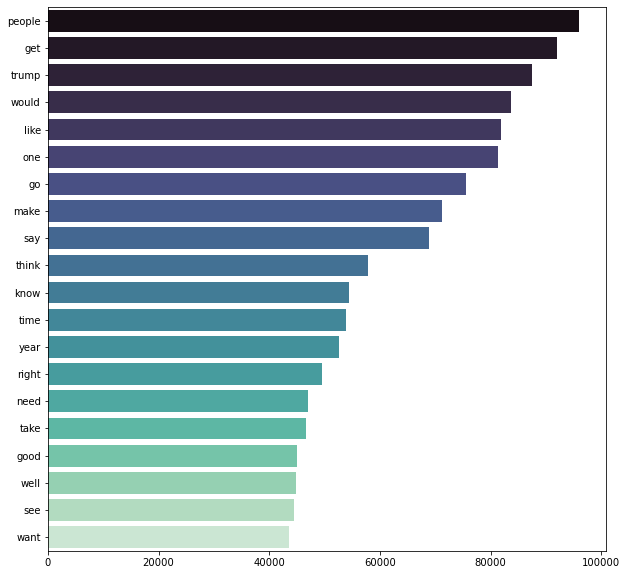

In [132]:
top_terms_df = pd.Series(top_terms)
fig, ax = plt.subplots(figsize=(10,10))
bully_plot = sns.barplot(x=top_terms_df.values, y=top_terms_df.index, ax=ax, palette="mako")
#plt.savefig('../images/FreqDist.jpg', transparent = False, bbox_inches="tight")

In [100]:
bully_train_df = train_df[is_target]['proc_text']
nonbully_train_df = train_df[~is_target]['proc_text']

In [102]:
bully_count_matrix = subpipe_text.fit_transform(bully_train_df)

CPU times: user 5.18 s, sys: 125 ms, total: 5.3 s
Wall time: 5.32 s


In [103]:
bully_count_sum = bully_count_matrix.sum(axis=0).tolist()[0]
bully_feature_names = subpipe_text.named_steps['cv'].get_feature_names_out()
bully_frequencies = dict(zip(bully_feature_names, bully_count_sum))

In [104]:
nonbully_count_matrix = subpipe_text.fit_transform(nonbully_train_df)

CPU times: user 5.05 s, sys: 129 ms, total: 5.18 s
Wall time: 5.2 s


In [105]:
nonbully_count_sum = nonbully_count_matrix.sum(axis=0).tolist()[0]
nonbully_feature_names = subpipe_text.named_steps['cv'].get_feature_names_out()
nonbully_frequencies = dict(zip(nonbully_feature_names, nonbully_count_sum))

In [106]:
top_bully_terms = dict(sorted(bully_frequencies.items(), key=lambda x:x[1], reverse=True)[:200])

In [107]:
top_nonbully_terms = dict(sorted(nonbully_frequencies.items(), key=lambda x:x[1], reverse=True)[:200])

In [110]:
bully_specific_terms = []
for key in top_bully_terms.keys():
    if not key in top_nonbully_terms:
        bully_specific_terms.append(key)

print(bully_specific_terms)
bully_specific_frequencies = {key: bully_frequencies[key] for key in bully_specific_terms}

['white', 'kill', 'stupid', 'lie', 'black', 'racist', 'muslim', 'gun', 'america', 'hate', 'idiot', 'attack', 'men', 'hillary', 'clinton', 'kid', 'they', 're', 'head', 'democrat', 'name', 'crime', 'act', 'group', 'police', 'death', 'oh', 'feel', 'll', 'human', 'hand', 'claim', 'trudeau']


In [112]:
nonbully_specific_terms = []
for key in top_nonbully_terms.keys():
    if not key in top_bully_terms:
        nonbully_specific_terms.append(key)

print(nonbully_specific_terms)
nonbully_specific_frequencies = {key: nonbully_frequencies[key] for key in nonbully_specific_terms}

['cost', 'city', 'http', 'oil', 'alaska', 'home', 'best', 'question', 'less', 'story', 'company', 'include', 'com', 'write', 'interest', 'plan', 'move', 'church', 'health', 'www', 'understand', 'least', 'number', 'next', 'increase', 'fund', 'low', 'mr', 'service', 'buy', 'income', 'provide', 'etc']


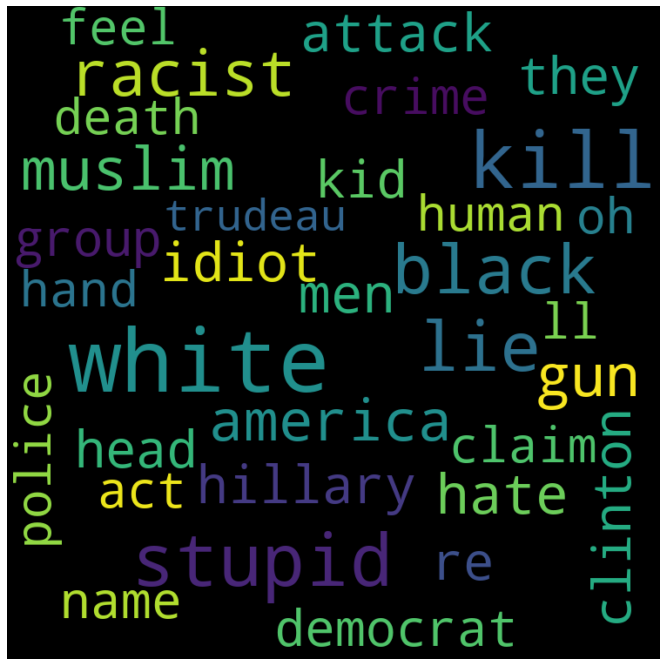

In [133]:
bully_wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=750, height=750).generate_from_frequencies(bully_specific_frequencies);
#bully_wordcloud.to_file("../images/bully_wordcloud.png")
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.imshow(bully_wordcloud, interpolation="bilinear")
plt.axis("off");

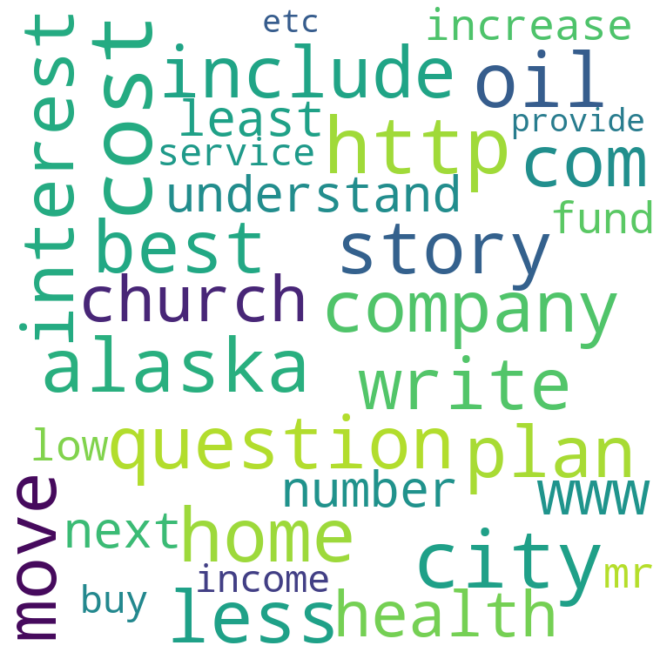

In [134]:
nonbully_wordcloud = WordCloud(min_font_size=10, max_font_size=100, 
                      width=750, height=750,
                      background_color='white').generate_from_frequencies(nonbully_specific_frequencies);
#nonbully_wordcloud.to_file("../images/nonbully_wordcloud.png")
plt.rcParams['figure.figsize'] = [12, 12]
plt.figure()
plt.imshow(nonbully_wordcloud, interpolation="bilinear")
plt.axis("off");